In [41]:
library(tidyverse)
library(tidymodels)
library(repr)

In [42]:
stroke <- read_csv("https://raw.githubusercontent.com/Megunight/dsci100-project/main/stroke_prediction_dataset.csv")

Rows: 15000 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): Patient Name, Gender, Marital Status, Work Type, Residence Type, S...
dbl  (8): Patient ID, Age, Hypertension, Heart Disease, Average Glucose Leve...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [43]:
names(stroke) <- c("patient_id", "patient_name", "age", "gender", "hypertension", "heart_disease", "marital_status",
                  "work_type", "residence_type", "average_glucose_level", "bmi", "smoking_status", "alcohol_intake", "physical_activity",
                  "stroke_history", "family_history_of_stroke", "dietary_habits", "stress_levels", "blood_pressure_levels",
                  "cholesterol_levels", "symptoms", "diagnosis")
head(stroke)

patient_id,patient_name,age,gender,hypertension,heart_disease,marital_status,work_type,residence_type,average_glucose_level,⋯,alcohol_intake,physical_activity,stroke_history,family_history_of_stroke,dietary_habits,stress_levels,blood_pressure_levels,cholesterol_levels,symptoms,diagnosis
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,⋯,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,⋯,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,⋯,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,⋯,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Headache, Confusion",No Stroke
48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,⋯,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke
29307,Advika Kota,62,Female,0,0,Single,Private,Urban,91.60,⋯,Social Drinker,High,0,No,Gluten-Free,4.85,132/64,"HDL: 80, LDL: 69",Severe Fatigue,Stroke


In [44]:
#Seven different variables have been selected for use

stroke_selected <- stroke |>
                    select(age,
                           hypertension,
                           stress_levels,
                           diagnosis)

In [45]:
stroke_sample <- stroke_selected |>
                sample_n(5000)

In [46]:
stroke_split <- initial_split(stroke_sample, prop = 0.75, strata = diagnosis)
stroke_training <- training(stroke_split)
stroke_testing <- testing(stroke_split)

In [47]:
stroke_training <- stroke_training |>
  mutate(stress_level_category = case_when(
    stress_levels <= 2.5 ~ "Low",
    stress_levels > 2.5 & stress_levels <= 5.0 ~ "Moderate",
    stress_levels > 5.0 & stress_levels <= 7.5 ~ "High",
    stress_levels > 7.5 ~ "Very High") )


stroke_training <- stroke_training |>
    mutate(age_group = cut(age, breaks = seq(0, 100, by = 10), labels = seq(0, 90, by = 10), right = FALSE)) |>
    mutate(hypertension = as_factor(hypertension)) |>
    mutate(hypertension = fct_recode(hypertension, "False" = "0", "True" = "1"))

stroke_testing <- stroke_testing |>
  mutate(stress_level_category = case_when(
    stress_levels <= 2.5 ~ "Low",
    stress_levels > 2.5 & stress_levels <= 5.0 ~ "Moderate",
    stress_levels > 5.0 & stress_levels <= 7.5 ~ "High",
    stress_levels > 7.5 ~ "Very High") )


stroke_testing <- stroke_testing |>
    mutate(age_group = cut(age, breaks = seq(0, 100, by = 10), labels = seq(0, 90, by = 10), right = FALSE)) |>
    mutate(hypertension = as_factor(hypertension)) |>
    mutate(hypertension = fct_recode(hypertension, "False" = "0", "True" = "1"))


In [48]:
stroke_training <- stroke_training |>
    mutate(diagnosis_group = fct_recode(diagnosis, "0" = "No Stroke", "1" = "Stroke"))

stroke_testing <- stroke_testing |>
    mutate(diagnosis_group = fct_recode(diagnosis, "0" = "No Stroke", "1" = "Stroke"))

In [49]:
stroke_obs <- stroke_training |>
                group_by(diagnosis_group) |>
                summarise(count = n())
stroke_obs


diagnosis_group,count
<fct>,<int>
0,1906
1,1843


Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


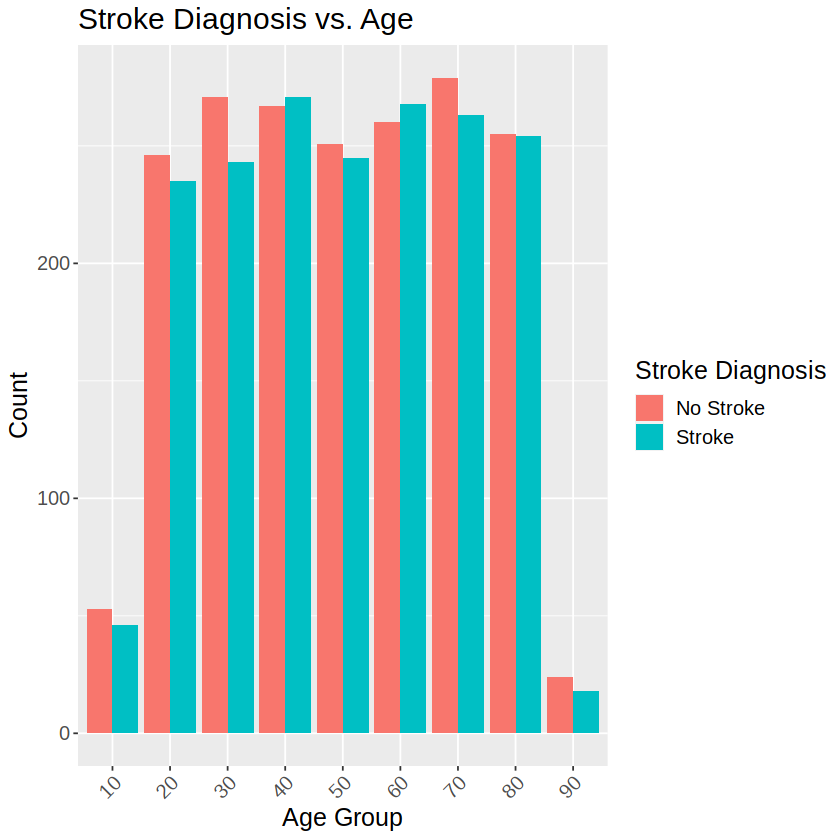

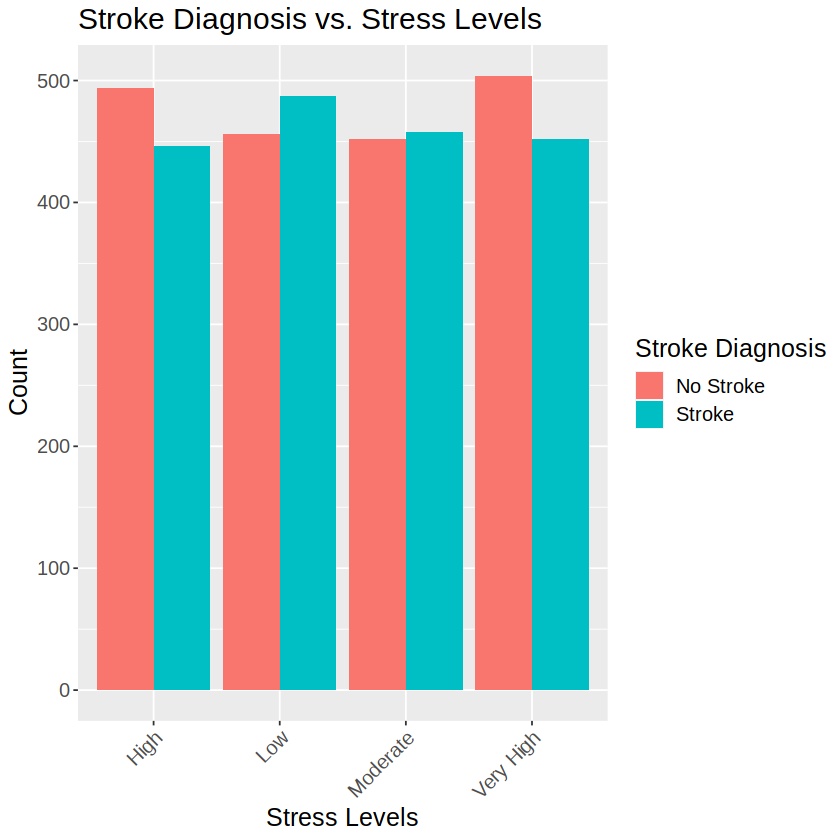

In [50]:
set.seed(560)
options(repr.plot.width = 7, repr.plot.height = 7)

stroke_age <- stroke_training |>
            ggplot(aes(x = age_group, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Age Group", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Age") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_age

stroke_stress <- stroke_training |>
            ggplot(aes(x = stress_level_category, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Stress Levels", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Stress Levels") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_stress


In [69]:
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [121]:
stroke_recipe <- recipe(diagnosis_group ~ age + stress_levels, data = stroke_training)

In [122]:
stroke_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

In [123]:
stroke_vfold <- vfold_cv(stroke_training, v = 5, strata = diagnosis_group) 

grid_values <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

stroke_workflow <- workflow() |>
                    add_recipe(stroke_recipe) |>
                    add_model(stroke_spec) |>
                    tune_grid(resamples = stroke_vfold, grid = grid_values) |>
                    collect_metrics()


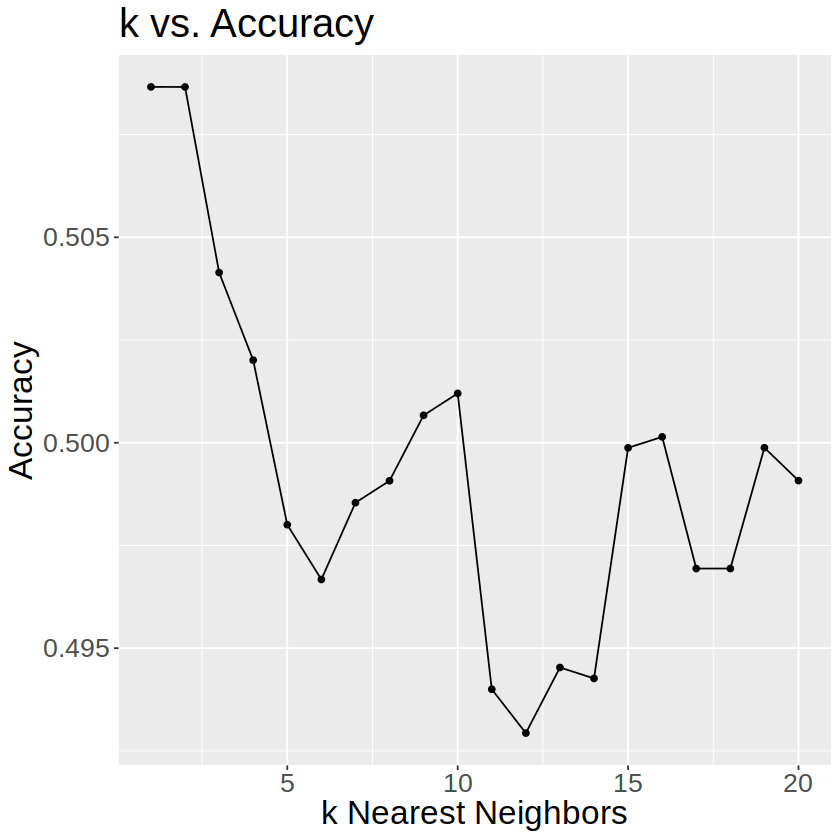

In [124]:
stroke_accuracies <- stroke_workflow |>
                        filter(.metric == "accuracy") 
                        
cross_val_plot <- ggplot(stroke_accuracies, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                  labs(title = "k vs. Accuracy",
                       x = "k Nearest Neighbors",
                       y = "Accuracy") +
                  theme(text = element_text(size = 20))
cross_val_plot

In [125]:
stroke_spec_matrix <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
            set_engine("kknn") |>
            set_mode("classification")

stroke_fit <- workflow() |>
            add_recipe(stroke_recipe) |>
            add_model(stroke_spec_matrix) |>
            fit(data = stroke_training)


In [126]:
stroke_predictions <- predict(stroke_fit, stroke_testing) |>
                        bind_cols(stroke_testing)

stroke_predictions <- stroke_predictions |>
            mutate(.pred_class = fct_recode(.pred_class, "0" = "No Stroke", "1" = "Stroke"))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `.pred_class = fct_recode(.pred_class, `0` = "No Stroke", `1` =
  "Stroke")`.
Caused by warning:
! Unknown levels in `f`: No Stroke, Stroke”


In [127]:
stroke_metrics <- stroke_predictions |>
                        metrics(truth = diagnosis_group, estimate = .pred_class) |>
                        filter(.metric == "accuracy")

In [128]:
stroke_conf_mat <- stroke_predictions |>
                conf_mat(truth = diagnosis_group, estimate = .pred_class)
stroke_conf_mat

          Truth
Prediction   0   1
         0 342 316
         1 294 299

In [119]:
head(stroke_training)
temp_graph <- ggplot(stroke_training, aes(x=stress_level_category

age,hypertension,stress_levels,diagnosis,stress_level_category,age_group,diagnosis_group
<dbl>,<fct>,<dbl>,<chr>,<chr>,<fct>,<fct>
29,True,4.49,No Stroke,Moderate,20,0
36,True,9.58,No Stroke,Very High,30,0
86,True,2.36,No Stroke,Low,80,0
90,True,9.71,No Stroke,Very High,90,0
82,True,3.39,No Stroke,Moderate,80,0
33,False,1.53,No Stroke,Low,30,0
